In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# openPMD beamphysics examples

In [2]:
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.particles import particle_paths, all_components, component_str

from h5py import File
import os

In [3]:
# Open a file, fine the particle paths from the root attributes
# Pick one:
#H5FILE = 'data/bmad_particles.h5'
H5FILE = 'data/distgen_particles.h5'
#H5FILE = 'data/astra_particles.h5'
h5 = File(H5FILE)


ppaths = particle_paths(h5)
ppaths

['/data/0/particles/']

In [4]:
# Point to particles
ph5 = h5[ppaths[0]]
list(ph5)

['momentum', 'position', 'time', 'weight']

In [5]:
# Search for all valid components
all_components(ph5)

['momentum/x',
 'momentum/y',
 'momentum/z',
 'position/x',
 'position/y',
 'position/z',
 'time',
 'weight']

In [6]:
# Get some info
for component in all_components(ph5):
    info = component_str(ph5, component)
    print(info)

momentum/x [10000 items] is a momentum with units: kg*m/s
momentum/y [10000 items] is a momentum with units: kg*m/s
momentum/z [10000 items] is a momentum with units: kg*m/s
position/x [10000 items] is a length with units: m
position/y [10000 items] is a length with units: m
position/z [10000 items] is a length with units: m
time [10000 items] is a time with units: s
weight [10000 items] is a charge with units: C, but expected units: C


# ParticleGroup class

In [7]:
# Parse all these into a class
P = ParticleGroup(ph5)

In [8]:
?P

Type:        ParticleGroup
String form: ParticleGroup with 10000 particles with total charge 2.3e-09 C
File:        ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/particles.py
Docstring:  
Particle Group class

Initialized on on openPMD beamphysics particle group.

The fundamental bunch data is stored in __dict__ with keys
    str: species
    int: n_particle
    np.array: x, px, y, py, z, pz, t, status, weight
where:
    x, y, z are positions in units of [m]
    px, py, pz are momenta in units of [eV/c]
    t is time in [s]
    weight is the macro-charge weight in [C], used for all statistical calulations.
    
Derived data can be computed as attributes:
    .gamma, .beta, .beta_x, .beta_y, .beta_z: relativistic factors [1].
    .energy, .kinetic_energy: energy, energy - mc2 in [eV]. 
    .p: total momentum in [eV/c]
    .mass: rest mass in [eV]
    
Statistics of any of these are calculated with:
    .min(X)
    .max(X)
    .ptp(X)
    .avg(X)
    .std(X)
    .cov(X, Y, ...)
    w

In [9]:
# x positions, in meters
P.x

array([0.00010713, 0.00034532, 0.00024771, ..., 0.00038017, 0.00028772,
       0.00046803])

In [10]:
# relativistic gamma, calculated on the fly
P.gamma

array([1.00000219, 1.00000203, 1.00000202, ..., 1.00000221, 1.00000192,
       1.00000205])

In [11]:
# Statistics on any of these. Note that these properly use the .weight array. 
P.avg('gamma'), P.std('p')

(1.0000004403138203, 186.2248378137966)

In [12]:
# Covariance matrix of any list of keys
P.cov('x', 'px', 'y', 'px')

array([[ 5.53424144e-08, -2.83169902e-05, -8.85128475e-14,
        -2.83169902e-05],
       [-2.83169902e-05,  7.66575022e+04, -2.98184924e-05,
         7.66575022e+04],
       [-8.85128475e-14, -2.98184924e-05,  5.53424144e-08,
        -2.98184924e-05],
       [-2.83169902e-05,  7.66575022e+04, -2.98184924e-05,
         7.66575022e+04]])

In [13]:
# These can all be accessed with brackets. sigma_ and mean_ are also allowed
P['sigma_x'], P['sigma_energy'], P['min_y'], P['norm_emit_x']

(0.00023523792234909837,
 0.18297475640831348,
 -0.0004981677461026075,
 1.2746364511228228e-07)

In [14]:
# Units
P.units('x'), P.units('energy'), P.units('norm_emit_x')

('m', 'eV', 'm*rad')

In [15]:
# These particles are from Bmad, at the same z and different times
P.std('z'), P.std('t')

(0.0, 8.499999999999998e-12)

In [16]:
# Get the central time
t0 = P.avg('t')
t0

1.8846240950683415e-29

In [17]:
# Drift all particles to this time
P.drift_to_t(t0)

In [18]:
# Now these are at different z, and the same t
P.std('z'), P.avg('t'), set(P.t)

(1.3782686402625986e-06, 1.8846240950683418e-29, {1.8846240950683415e-29})

In [19]:
# Write Astra-style particles
P.write_astra('astra.dat')

In [20]:
!head astra.dat

  1.535211903978e-09   1.856269541216e-09   1.070586479124e-09   6.271287796258e-15  -4.158380796802e-15   2.209872489179e+02   1.884624095068e-20   0.000000000000e+00    1   -1
  1.176211316871e-04   0.000000000000e+00  -1.070586479124e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00   1.401298464325e-45   0.000000000000e+00    1   -3
  0.000000000000e+00   1.176210509770e-04  -1.070586479124e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00  -1.401298464325e-45   0.000000000000e+00    1   -3
  2.352422633743e-04   0.000000000000e+00  -1.070586479124e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00   2.802596928650e-45   0.000000000000e+00    1   -3
  0.000000000000e+00   2.352421019540e-04  -1.070586479124e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00  -2.802596928650e-45   0.000000000000e+00    1   -3
  3.528633950614e-04   0.000000000000e+00  -1.070586479124e-09   0.000000000000e+00   0.000000000000e+00   0.0

# Plot

In [21]:
import matplotlib.pyplot as plt
import matplotlib
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
matplotlib.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


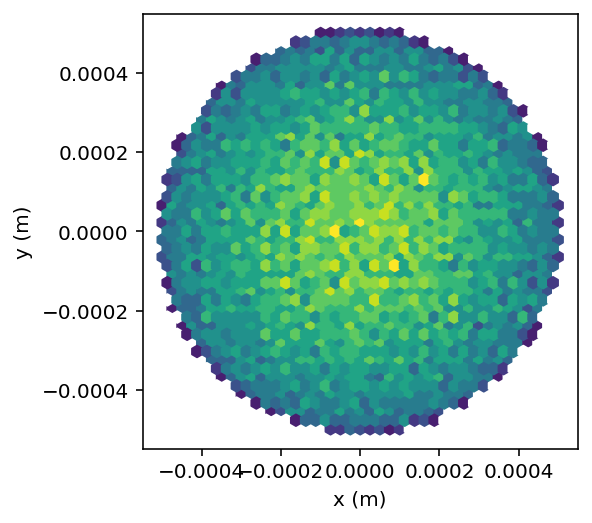

In [22]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
xkey = 'x'
ykey = 'y'
datx = P[xkey]
daty = P[ykey]
ax.set_xlabel(f'{xkey} ({P.units(xkey)})')
ax.set_ylabel(f'{ykey} ({P.units(ykey)})')
ax.hexbin(datx, daty, gridsize=40, cmap=cmap, vmin=1e-15)

In [23]:
# Cleanup
os.remove('astra.dat')